In [1]:
%load_ext autoreload
%autoreload 1
%aimport helpers, loaders, plotters 

In [26]:
# This helps with joblib "No space left on device" errors
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [1]:
from pprint import pprint
from math import ceil, floor
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from helpers import balanced_accuracy_scorer, balanced_accuracy, load_best_result, save_search_result, scikit_cv_result_to_df
from loaders import load_adult, load_mnist
from plotters import plot_means_w_stds, gen_and_plot_learning_curve, plot_learning_curve, gen_and_plot_validation_curve, plot_validation_curve

## Load and Preprocess Data

In [2]:
dataset = 'adult'
learner_type = 'KNN'
loader_func = load_adult

In [3]:
df = loader_func(preprocess=True)

Dataset shape (30162, 105)
Value composition:
0    0.751078
1    0.248922
Name: target, dtype: float64


### Split data into training and testing

In [4]:
X = df[[c for c in df.columns if c != 'target']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

### Scale Data

In [5]:
# Use min max scaling because input dataset is sparse, i.e. mostly zeros
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## KNN Model Selection

In [7]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()

In [12]:
param_grid = {
    'n_neighbors': range(1, 16),
    'weights': ['uniform', 'distance'],
}

In [9]:
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=balanced_accuracy_scorer,
    return_train_score=True,
    cv=4,
    verbose=1,
    n_jobs=-1,
)

In [10]:
grid_search.fit(X_train_scaled, y_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 26.9min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': range(1, 16), 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(balanced_accuracy), verbose=1)

In [11]:
save_search_result(grid_search, dataset, learner_type)

### Analysis

In [9]:
# res = grid_search.cv_results_
res = load_best_result(dataset, learner_type)
res_df = scikit_cv_result_to_df(res)
res_df.sort_values(by='rank_test_score').head(10)

Found the following results files for this dataset/algorithm: ['0.749_adult_KNN_2018-09-18_18-40-04-00.pkl']
Returning results for the highest-scoring-file: 0.749_adult_KNN_2018-09-18_18-40-04-00.pkl


,,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
n_neighbors,weights,,,,,,,,,
15,uniform,0.302700,0.003255,16.050710,0.336106,0.749188,0.002872,1,0.773662,0.001142
13,uniform,0.329925,0.022524,16.372293,0.151456,0.748269,0.003275,2,0.776797,0.001722
9,uniform,0.399882,0.070929,20.410653,0.540354,0.748121,0.006239,3,0.787032,0.001595
11,uniform,0.362788,0.102536,15.707246,0.222228,0.747540,0.004235,4,0.780166,0.001840
7,uniform,0.292467,0.020527,13.517263,0.264971,0.745202,0.003324,5,0.795927,0.001732
14,distance,0.328005,0.041895,16.431472,0.246185,0.744002,0.004926,6,0.999937,0.000063
5,uniform,0.313404,0.011798,12.704614,0.161904,0.743855,0.002115,7,0.810161,0.002917
15,distance,0.310260,0.002697,16.471544,0.160483,0.742638,0.004043,8,0.999937,0.000063
13,distance,0.334129,0.025383,15.880834,0.201444,0.742071,0.006239,9,0.999937,0.000063


In [10]:
distance = res_df.xs('distance', level='weights')
uniform = res_df.xs('uniform', level='weights')

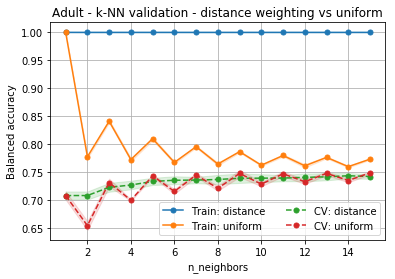

In [18]:
# Plot combined validation curve
plot_means_w_stds(
    means=(distance['mean_train_score'], uniform['mean_train_score'], distance['mean_test_score'], uniform['mean_test_score']),
    stds=(distance['std_train_score'], uniform['std_train_score'], distance['std_test_score'], uniform['std_test_score']),
    xrange=param_grid['n_neighbors'],
    xlabel='n_neighbors',
    ylabel='Balanced accuracy',
    series_labels=('Train: distance', 'Train: uniform', 'CV: distance', 'CV: uniform'),
    title='Adult - k-NN validation - distance weighting vs uniform',
    legend_kwargs={'loc': 'best', 'ncol': 2}
)

### Timing Analysis

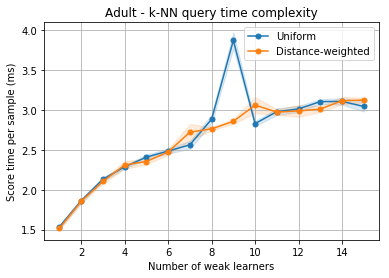

In [25]:
means = [uniform['mean_score_time'], distance['mean_score_time']]
stds = [uniform['std_score_time'], distance['std_score_time']]
labels = ['Uniform', 'Distance-weighted']

# Calculate per-sample mean
n_samples = X_train_scaled.shape[0] / 4 # one quarter of dataset was scored for 4-fold validation
means_per_samp = [mean / n_samples * 1000 for mean in means]
stds_per_samp = [std / n_samples * 1000 for std in stds]

plot_means_w_stds(
    means_per_samp,
    stds_per_samp,
    param_grid['n_neighbors'],
    series_labels=labels,
    title='Adult - k-NN query time complexity',
    legend_kwargs={'loc': 'best'},
    ylabel='Score time per sample (ms)',
    xlabel='Number of weak learners',
    linestyles=['-']*2,
#     fig_kwargs={'figsize': (10,6)},
)

## kNN Learning Curve Analysis

### What is the best estimator?

In [33]:
best_params = res['params'][np.argmax(res['mean_test_score'])]
clf = KNeighborsClassifier(**best_params)
clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': 1,
 'n_neighbors': 15,
 'p': 2,
 'weights': 'uniform'}

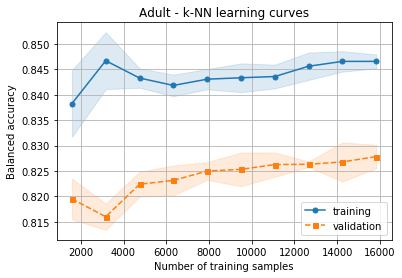

In [34]:
train_sizes, train_scores, test_scores, train_mean, train_std, test_mean, test_std = gen_and_plot_learning_curve(clf, X_train_scaled, y_train, ylabel='Balanced accuracy', cv=4, n_jobs=-1, title='Adult - k-NN learning curves')

# Performance on Test Set

In [35]:
best_clf = KNeighborsClassifier(**best_params)

best_clf.fit(X_train_scaled, y_train)
y_test_pred = best_clf.predict(X_test_scaled)
test_score = balanced_accuracy(y_test, y_test_pred)
print('%.4f' % test_score)

0.7480
